# 1. Description

__Aim:__      
Play with reinforcement learning based on gymnasium case - [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/).


__Algorithms to test__     
1. SARSA
2. Q-learning   

__Plan__     
1. Explore Taxi case
2. Create algorithms
3. Estimate their strategy depending on steps including repeats for estimation stabilization
4. Choice best one
5. Play the episode

## 2. Install

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gymnasium as gym

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from IPython import display

import random

import numpy as np

C:\Users\parshin_sa2\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from reward_funcs import SARSAReward, SARSAMeanReward, QReward
from learning_funcs import TDLearning

__Plot parameters__

In [5]:
# Matplotlib params
rcParams['figure.figsize'] = 24, 8
plt.set_loglevel('WARNING')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

sns.set_theme()
BASE_CONTEXT = 'fivethirtyeight'

# Plot
SHOW_ROWS = 600

# See palette
PALETTE = sns.color_palette()
print(PALETTE.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


__Constants__

In [6]:
SEED = 42
ACTIONS = {'down': 0, 'north': 1, 'east': 2, 'west': 3, 'pickup': 4, 'drop': 5}
TIME_LIMIT = 250
ATTEMPTS = 10

# 3. Describe Env

## 3.1. About Taxi v.3

__Description__   
The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends. There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue).   

__Action Space__   
The action shape is (1,) in the range {0, 5} indicating which direction to move the taxi or to pickup/drop off passengers.

* 0: Move south (down)

* 1: Move north (up)

* 2: Move east (right)

* 3: Move west (left)

* 4: Pickup passenger

* 5: Drop off passenger    
  
__Passenger locations__   

* 0: Red

* 1: Green

* 2: Yellow

* 3: Blue

* 4: In taxi

__Destinations__   

* 0: Red

* 1: Green

* 2: Yellow

* 3: Blue

Destination on the map are represented with the first letter of the color.   

__Rewards__   
* __-1__ per step unless other reward is triggered.

* __+20__ delivering passenger.

* __-10__ executing “pickup” and “drop-off” actions illegally.

An action that results a noop, like moving into a wall, will incur the time step penalty. Noops can be avoided by sampling the action_mask returned in info.   

__Other info__   

* Starting State: The episode starts with the player in a random state.   

* End:

    * Termination: 1. The taxi drops off the passenger.
    * Truncation (when using the time_limit wrapper): 1. The length of the episode is 200.   

There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.   
An observation is returned as an int() that encodes the corresponding state, calculated by ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination.   

## 3.2. Game general info

Observation space: 500
Action space: 6
Reward range: (-inf, inf)
Action space: Discrete(6)
Specification: EnvSpec(id='Taxi-v3', entry_point='gymnasium.envs.toy_text.taxi:TaxiEnv', reward_threshold=8, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='Taxi', version=3, additional_wrappers=(), vector_entry_point=None)
___
initial observation code: <TimeLimit<OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>>
taking action 1 (north)
___
New observation code: 286
reward: -1
is terminated?: False
is max episode steps exceed?: False
Info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}


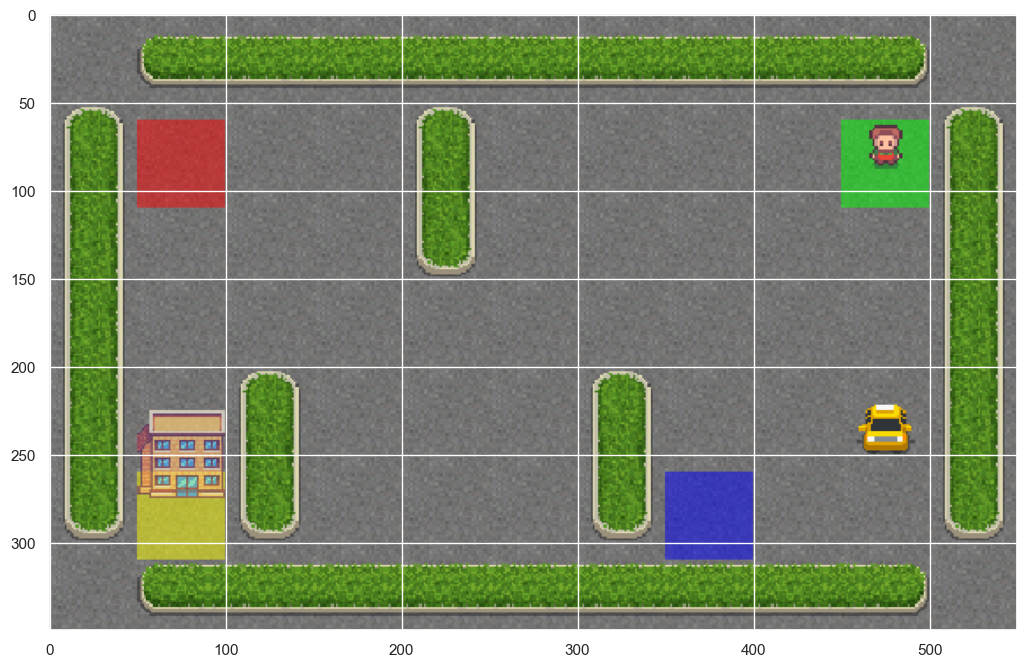

In [7]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
env.reset(seed=SEED)
plt.imshow(env.render());

print("Observation space:", env.observation_space.n)
print("Action space:", env.action_space.n)
print("Reward range:", env.reward_range)
print("Action space:", env.action_space)
print("Specification:", env.spec)
print("___")
print("initial observation code:", env)
print("taking action 1 (north)")
new_obs, reward, terminated, truncated, info = env.step(ACTIONS['north'])
print("___")
print("New observation code:", new_obs)
print("reward:", reward)
print("is terminated?:", terminated)
print("is max episode steps exceed?:", truncated)
print("Info:", info)

env.close()

## 3.3. Explore actions in the game

Let's try to finish episode. Seed is fixed, therefore steps are determined. On the ANSI map blue letter is passenger, Purple letter is destination.

In [8]:
env = gym.make('Taxi-v3', render_mode="ansi")
env.reset(seed=SEED)
cum_reward = 0

# Go up
for i in range(4):
    new_obs, reward, terminated, truncated, info = env.step(ACTIONS['north'])
    cum_reward += reward
# Pick up a passanger
new_obs, reward, terminated, truncated, info = env.step(ACTIONS['pickup'])
cum_reward += reward
print("After picking up")
print(f"New obs {new_obs}, reward {reward}, is terminated {terminated}, is truncated {truncated}")
print(f"Info {info}")
print(f"Total reward {cum_reward}")
print(env.render())
# Go down
for i in range(2):
    new_obs, reward, terminated, truncated, info = env.step(ACTIONS['down'])
    cum_reward += reward
# Go left
for i in range(4):
    new_obs, reward, terminated, truncated, info = env.step(ACTIONS['west'])
    cum_reward += reward
# Go down
for i in range(2):
    new_obs, reward, terminated, truncated, info = env.step(ACTIONS['down'])
    cum_reward += reward
# Ready to drop passenger
print("\nBefore dropping")
print(f"New obs {new_obs}, reward {reward}, is terminated {terminated}, is truncated {truncated}")
print(f"Info {info}")
print(f"Total reward {cum_reward}")
print(env.render())
# After propping passenger
print("\nAfter dropping")
new_obs, reward, terminated, truncated, info = env.step(ACTIONS['drop'])
cum_reward += reward
print(f"New obs {new_obs}, reward {reward}, is terminated {terminated}, is truncated {truncated}")
print(f"Info {info}")
print(f"Total reward {cum_reward} \n")
print(env.render())

env.close()

After picking up
New obs 98, reward -1, is terminated False, is truncated False
Info {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 1], dtype=int8)}
Total reward -5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)


Before dropping
New obs 418, reward -1, is terminated False, is truncated False
Info {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 1], dtype=int8)}
Total reward -13
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


After dropping
New obs 410, reward 20, is terminated True, is truncated False
Info {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 1, 0], dtype=int8)}
Total reward 7 

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



# 4. On-policy

# 4.1. SARSA

In [9]:
GAMMA = 0.9
ALPHA = 0.6
STEPS = 1_000
TOTAL_EPISODES = 10_000
EPSILON = lambda n: 1. / (np.log(n) + 1) # lambda n: 1. / (np.log(n) + 1)
NUM_EXPERIMENTS, NUM_EXPERIMENTS_PI = 5, 10
ENV = gym.make('Taxi-v3', render_mode="ansi")
ENV.reset(seed=SEED)

(386, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [13]:
# REWARD FUNCTION
sarsa_reward_cls = SARSAReward(alpha=ALPHA, gamma=GAMMA, action_space=ENV.action_space.n)

In [144]:
sarsa_learning_cls = TDLearning(env=ENV, action_space=ENV.action_space.n)
sarsa_Qs, sarsa_policies, sarsa_rewards = sarsa_learning_cls.compute_episodes(TOTAL_EPISODES, STEPS, sarsa_reward_cls, EPSILON)
sarsa_learning_cls.env_close()

100%|██████████| 10000/10000 [00:32<00:00, 303.87it/s]


In [145]:
print(f"Current policy:\n shape={sarsa_policies[-1].shape}\n{np.reshape(sarsa_policies[-1], (50, 10))[:5, :]}")
np.set_printoptions(precision=6, suppress=True)
print(f"Resulting Q:\n shape={sarsa_Qs[-1].shape}\n{sarsa_Qs[-1]}")
print(f"Resulting reward on the last Q:\n reward={sarsa_rewards[-1]}")

Current policy:
 shape=(500,)
[[0 4 4 4 0 1 0 0 0 0]
 [0 0 2 0 2 4 5 0 0 0]
 [5 3 1 3 3 1 0 0 0 0]
 [4 1 0 0 0 3 3 0 3 3]
 [5 2 1 2 2 5 2 2 2 0]]
Resulting Q:
 shape=(500, 6)
[[  0.935757   0.372325   0.855563   0.867079   0.435371   0.81156 ]
 [ -5.126209  -8.613177 -11.435491  -5.009781  -0.111194 -14.495236]
 [ -2.477645  -1.607613  -1.093357   0.91107    4.304328  -5.896084]
 ...
 [ -0.453007   9.942984  -0.230256  -2.210409  -3.755996  -3.967816]
 [-14.723298  -7.9791    -6.417836  -4.326824 -17.858571 -13.449783]
 [  4.863816   3.26995   -0.194355  17.741135  -0.482281   3.657134]]
Resulting reward on the last Q:
 reward=7


In [146]:
# 10 agents, num of test episodes after each episode
sarsa_learning_cls = TDLearning(env=ENV, action_space=ENV.action_space.n)
sarsa_res, sarsa_policies_episodes = sarsa_learning_cls.compute_experiments_episodes(NUM_EXPERIMENTS, NUM_EXPERIMENTS_PI, TOTAL_EPISODES, STEPS, sarsa_reward_cls, EPSILON, seed=None)

100%|██████████| 10000/10000 [1:09:45<00:00,  2.39it/s]


# 5. Off-policy

# 5.1. Q-learning

In [147]:
ENV = gym.make('Taxi-v3', render_mode="ansi")
ENV.reset(seed=SEED)

(386, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [14]:
# REWARD FUNCTION
q_reward_cls = QReward(alpha=ALPHA, gamma=GAMMA, action_space=ENV.action_space.n)

Compute policies and actions

In [18]:
q_learning_cls = TDLearning(env=ENV, action_space=ENV.action_space.n)
q_Qs, q_policies, q_rewards = q_learning_cls.compute_episodes(TOTAL_EPISODES, STEPS, q_reward_cls, EPSILON)
q_learning_cls.env_close()

100%|██████████| 10000/10000 [00:13<00:00, 723.46it/s]


Observe some results

In [19]:
print(f"Current policy:\n shape={q_policies[-1].shape}\n{np.reshape(q_policies[-1], (50, 10))[:5, :]}")
np.set_printoptions(precision=6, suppress=True)
print(f"Resulting Q:\n shape={q_Qs[-1].shape}\n{q_Qs[-1]}")
print(f"Resulting reward on the last Q:\n reward={q_rewards[-1]}")

Current policy:
 shape=(500,)
[[5 4 4 4 0 4 0 0 0 0]
 [2 0 2 2 0 4 5 0 0 2]
 [5 3 3 3 0 2 0 0 0 0]
 [3 0 0 0 0 3 3 0 3 0]
 [5 2 0 0 2 3 2 2 0 0]]
Resulting Q:
 shape=(500, 6)
[[  0.723185   0.712512   0.499189   0.861239   0.645694   0.975469]
 [ -0.305385   0.771805  -0.305391   0.771792   1.968673  -8.228585]
 [  4.574075   6.194072   4.574665   6.194072   7.993414  -2.805931]
 ...
 [  8.242144  10.269053   8.242146   6.417931  -0.757852  -0.757854]
 [ -4.19593    3.117199  -0.655333  -4.150202  -7.555791 -11.517696]
 [ -0.428788  -0.798655   8.699189  17.752724   5.235993   3.718494]]
Resulting reward on the last Q:
 reward=6


Observe several experiments

In [151]:
# 10 agents, num of test episodes after each episode
q_learning_cls = TDLearning(env=ENV, action_space=ENV.action_space.n)

q_res, q_policies_episodes = q_learning_cls.compute_experiments_episodes(NUM_EXPERIMENTS, NUM_EXPERIMENTS_PI, TOTAL_EPISODES, STEPS, q_reward_cls, EPSILON)

100%|██████████| 10000/10000 [1:06:58<00:00,  2.49it/s]    


# 6. Outcomes

Text(0.5, 0, 'Episodes')

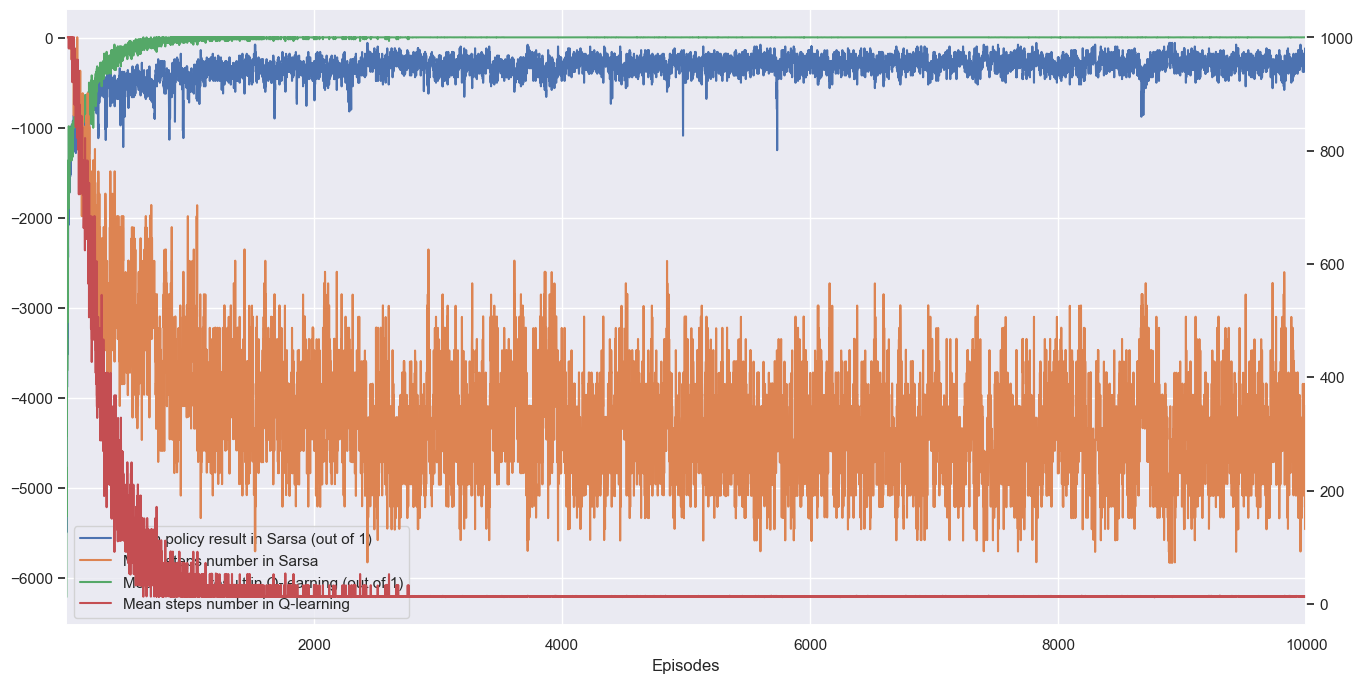

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns = np.mean( np.array([ [x[0] for x in res] for res in sarsa_res]), axis=1)
avg_steps = np.mean( np.array([ [x[1] for x in res] for res in sarsa_res]), axis=1)
avg_returns_q = np.mean( np.array([ [x[0] for x in res] for res in q_res]), axis=1)
avg_steps_q = np.mean( np.array([ [x[1] for x in res] for res in q_res]), axis=1)

line1 = ax.plot(np.arange(1, TOTAL_EPISODES+1), avg_returns, label="Mean policy result in Sarsa (out of 1)", color="C0")  # 
line2 = ax2.plot(np.arange(1, TOTAL_EPISODES+1), avg_steps, label="Mean steps number in Sarsa", color="C1")  # to get finish
line3 = ax.plot(np.arange(1, TOTAL_EPISODES+1), avg_returns_q, label="Mean policy result in Q-learning (out of 1)", color="C2")  # 
line4 = ax2.plot(np.arange(1, TOTAL_EPISODES+1), avg_steps_q, label="Mean steps number in Q-learning", color="C3")  # to get finish

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)
# ax.set_xlim((0.5, 1.0))
# ax.legend(loc="upper right")
ax.set_xlim((1, TOTAL_EPISODES))
ax.set_xlabel("Episodes")

In [161]:
print("SARSA learning average reward", np.mean(np.array([ [x[0] for x in res] for res in sarsa_res]), axis=1)[-10:])
print("SARSA learning steps", np.mean(np.array([ [x[1] for x in res] for res in sarsa_res]),  axis=1)[-10:])

print("Q-learning average reward", np.mean(np.array([ [x[0] for x in res] for res in q_res]), axis=1)[-10:])
print("Q-learning steps", np.mean(np.array([ [x[1] for x in res] for res in q_res]),  axis=1)[-10:])

SARSA learning average reward [-295.08 -113.28 -254.18 -194.6  -133.52 -133.82 -113.94 -254.06 -193.88
 -275.22]
SARSA learning steps [309.78 131.76 269.72 211.4  151.58 151.88 132.42 269.6  210.68 290.34]
Q-learning average reward [7.36 7.74 8.02 7.6  8.06 8.1  7.92 8.1  8.2  8.54]
Q-learning steps [13.64 13.26 12.98 13.4  12.94 12.9  13.08 12.9  12.8  12.46]


Ideal raward is nearly 7. Q-learning looks more stable and effective. The result is nearly 7 with steps ~13. 

# 7. Replay episode

In [20]:
GAMMA = 0.9
ALPHA = 0.6
STEPS = 1000
TOTAL_EPISODES = 10_000
EPSILON = lambda n: 1. / (np.log(n) + 1) # lambda n: 1. / (np.log(n) + 1)
NUM_EXPERIMENTS, NUM_EXPERIMENTS_PI = 5, 10
ENV = gym.make('Taxi-v3', render_mode="ansi")
ENV.reset(seed=None)

q_reward_cls = QReward(alpha=ALPHA, gamma=GAMMA, action_space=ENV.action_space.n)
q_learning_cls = TDLearning(env=ENV, action_space=ENV.action_space.n)
sarsa_reward_cls = SARSAReward(alpha=ALPHA, gamma=GAMMA, action_space=ENV.action_space.n)
sarsa_learning_cls = TDLearning(env=ENV, action_space=ENV.action_space.n)

100%|██████████| 10000/10000 [00:13<00:00, 731.48it/s]


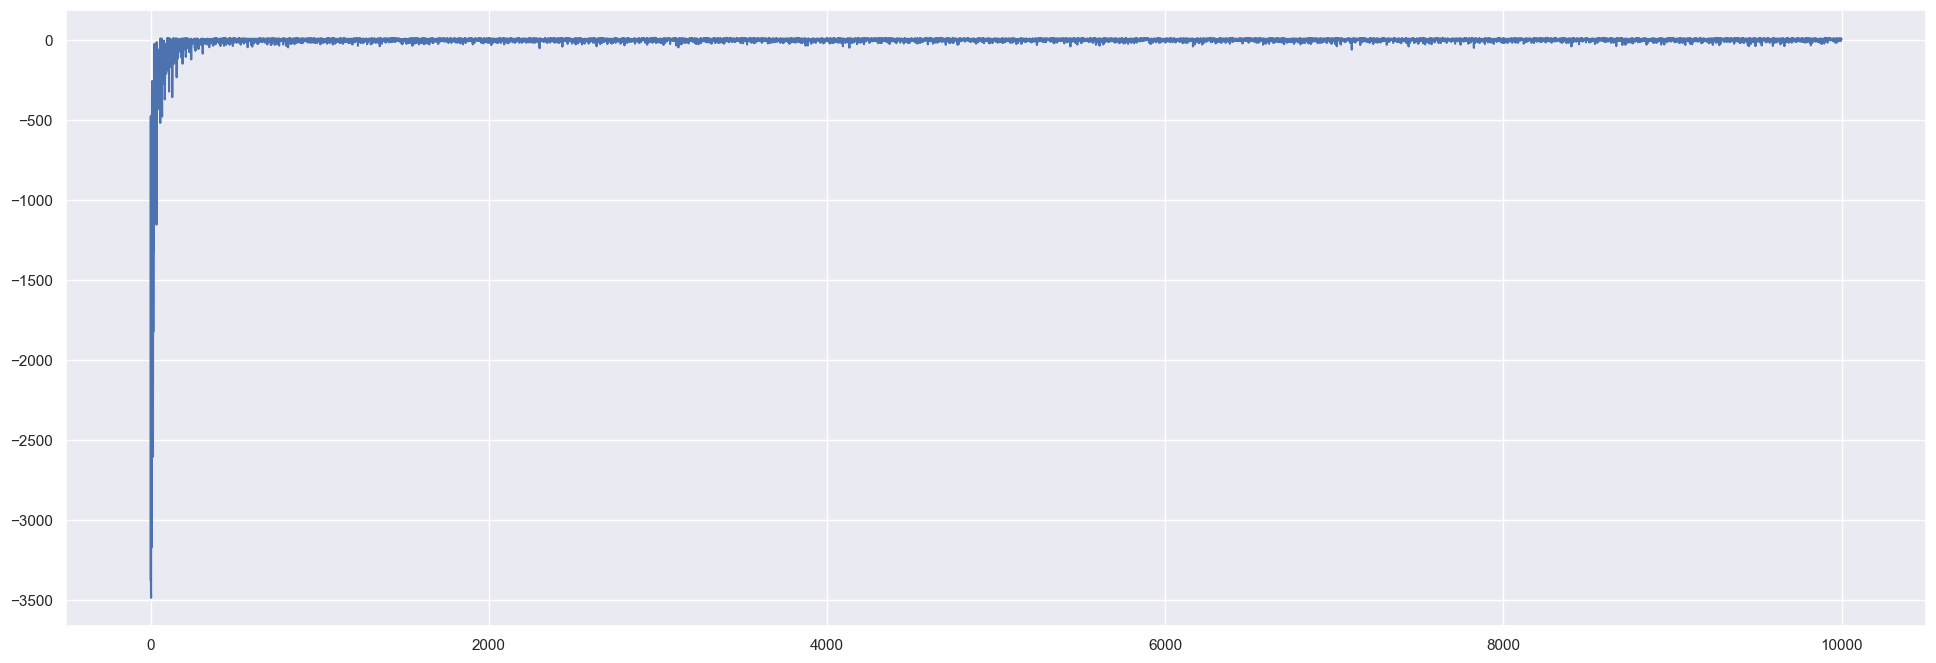

In [21]:
q_Qs, q_policies, q_rewards = q_learning_cls.compute_episodes(TOTAL_EPISODES, STEPS, q_reward_cls, EPSILON)
q_learning_cls.env_close()

plt.plot(q_rewards)
plt.show()

100%|██████████| 10000/10000 [00:22<00:00, 439.54it/s]


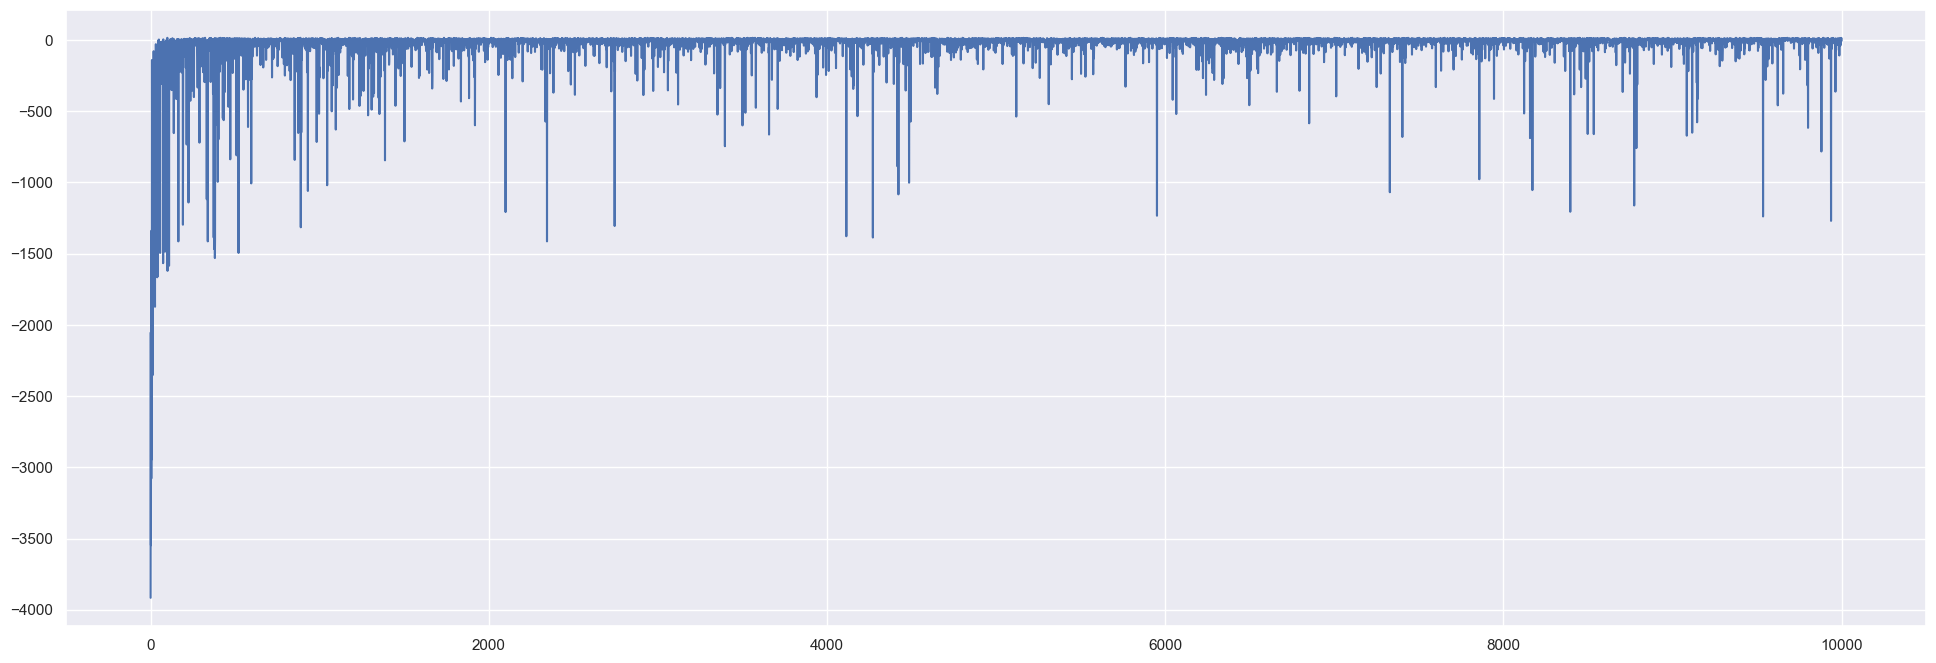

In [22]:
sarsa_Qs, sarsa_policies, sarsa_rewards = sarsa_learning_cls.compute_episodes(TOTAL_EPISODES, STEPS, sarsa_reward_cls, EPSILON)
sarsa_learning_cls.env_close()

plt.plot(sarsa_rewards)
plt.show()

In [23]:
print("SARSA last rewards:", sarsa_rewards[-20:])
print("Q-learning last rewards:", q_rewards[-20:])

SARSA last rewards: [11, -16, -1, 1, -27, 7, -109, -2, -14, -29, 14, 6, 1, -38, -3, -2, -11, 8, 14, -6]
Q-learning last rewards: [-6, -4, -4, -6, 12, 13, 7, 5, -2, 5, 6, 8, 10, 8, 5, -5, 0, 12, 7, 6]


Play the game!

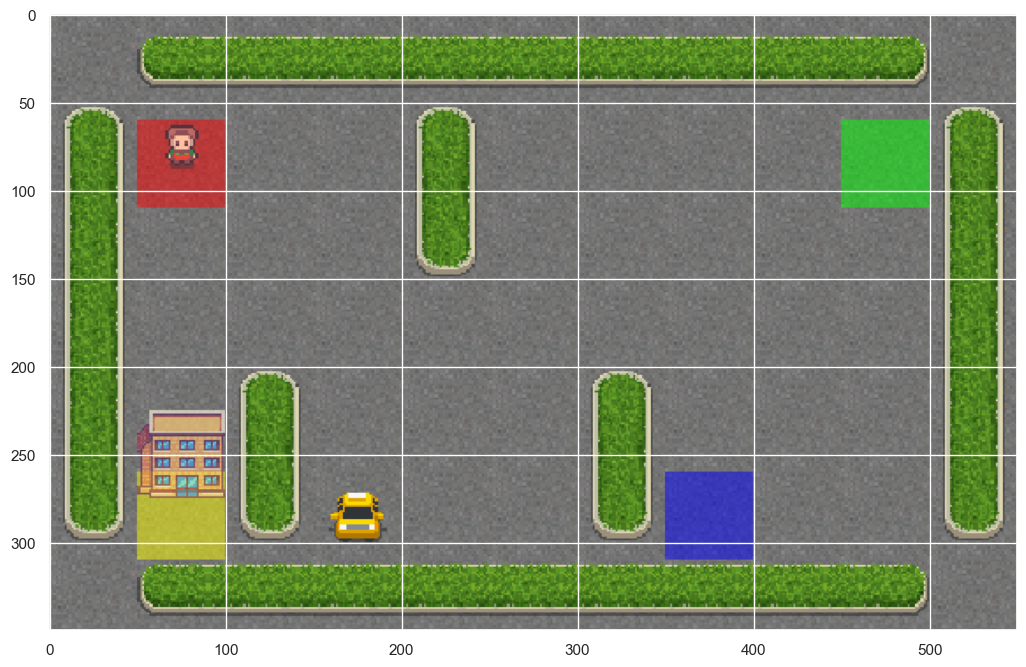

In [29]:
# Take last policy
policy_to_play = q_policies[-1] # q_policies[-1] sarsa_policies[-1]
q_to_play = q_Qs[-1] # q_Qs[-1] sarsa_Qs[-1]


for n in range(ATTEMPTS):
    ENV = gym.make('Taxi-v3', render_mode="rgb_array")
    ENV.reset()
    display.clear_output(wait=True)
    rewards = 0
    action_space = ENV.action_space.n
    state = ENV.env.s


    for t in range(TIME_LIMIT):
        plt.gca().clear()
        # Call your policy
        eps = EPSILON(t)
        actions = policy_to_play[state]
        possible_actions = q_to_play[state]
        top_action = actions.argmax()
        # Take the most success strategy with small random
        if np.random.rand() > eps :
            action = top_action
        else:
            actions_choice = [act for act in range(action_space) if act != top_action]
            weights = possible_actions[actions_choice]
            offset = min(weights)
            positiveweights = [z - offset + 1 for z in weights]
            action = random.choices(actions_choice, positiveweights)[0]
        
        # Pass the action chosen by the policy to the environment
        state, reward, terminated, truncated, info = ENV.step(action)
        rewards += reward

        # Draw game image on display.
        plt.imshow(ENV.render());
        
        display.display(plt.gcf())
        display.clear_output(wait=True)

        if terminated:
            print("Well done!")
            print("Reward =", rewards)
            break
        if truncated:
            print("Time limit exceeded. Try again.")
            print("Reward =", rewards)
            break
    if terminated:
        break

Often it is not success:-(